In [1]:
import json
from pandas import DataFrame, concat, set_option
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

set_option('display.max_colwidth', None) 

Load Data

In [2]:
test_data_file = '../data/sarc/dev-comments-balanced.json'
model_out_files = ['../outputs/D3/d3_baseline.out', '../outputs/D3/d3_roberta.out', '../outputs/D3/d3_context.out', '../outputs/D3/d3_combined.out']

with open(test_data_file, 'r') as f:
    test_data = json.load(f)

model_out_dicts = []

for model_out_file in model_out_files:
    with open(model_out_file, 'r') as f:
        # save output file in dict
        model_out = {'pred':[], 'gold':[], 'prob_negative':[], 'prob_positive':[]}

        for line in f:
            lst = line.replace(',', '').split()
            # index labels and probabilities from each line, store in dict
            model_out['pred'].append(lst[1])
            model_out['gold'].append(lst[3])
            model_out['prob_negative'].append(lst[5])
            model_out['prob_positive'].append(lst[6])
        
        model_out_dicts.append(model_out)

Create Dataframes

In [3]:
# BERT baseline:
df1 = DataFrame.from_dict(model_out_dicts[0])
df2 = DataFrame.from_records(test_data)             # same test data for all models

baseline = concat([df2['response'], df1], axis=1)

# RoBERTa:
df1 = DataFrame.from_dict(model_out_dicts[1])

roberta = concat([df2['response'], df1], axis=1)

# Context:
df1 = DataFrame.from_dict(model_out_dicts[2])

context = concat([df2['response'], df1], axis=1)

# Combined
df1 = DataFrame.from_dict(model_out_dicts[3])

combined = concat([df2['response'], df1], axis=1)

In [4]:
# quickly check stats
print(baseline.describe())
print(roberta.describe())
print(context.describe())
print(combined.describe())

       response   pred   gold       prob_negative         prob_positive
count     25708  25708  25708               25708                 25708
unique    25501      2      2               25426                 25383
top         lol      1      1  0.9821178317070007  0.017882222309708595
freq         10  13222  12854                  21                    21
       response   pred   gold       prob_negative        prob_positive
count     25708  25708  25708               25708                25708
unique    25501      2      2               25125                24336
top         lol      1      1  0.9494456648826599  0.05055433511734009
freq         10  13676  12854                  10                   10
       response   pred   gold       prob_negative       prob_positive
count     25708  25708  25708               25708               25708
unique    25501      2      2               25674               25672
top         lol      1      1  0.9722469449043274  0.9676519632339478
freq 

In [5]:
# swap in different baselines to check proper loading
combined.head()

,response,pred,gold,prob_negative,prob_positive
0,Religion must have the answer,1,1,0.03765542060136795,0.9623446464538574
1,"It's obviously tracks from a giant water tractor, farming for giant arctic sea prawn!",1,0,0.04821109026670456,0.9517889618873596
2,Wow...he smoked pot...oh lord hes such a horrible person now..,1,1,0.0389789454638958,0.9610210657119751
3,"Wow, his girlfriend is uhm... Ah fuck it, he's an olympic champion, who am I to pass judgement...",1,0,0.05695034936070442,0.9430496692657471
4,I think the government should track every mormon in the country for subversive activity.,1,0,0.04075869172811508,0.9592412710189819


Incorrect classifications

In [6]:
# print 20 of the incorrectly classified examples
print(baseline.loc[baseline['pred'] != roberta['gold']].head(20))

                                                                                                                                                                                        response  \
1                                                                                                          It's obviously tracks from a giant water tractor, farming for giant arctic sea prawn!   
3                                                                                              Wow, his girlfriend is uhm... Ah fuck it, he's an olympic champion, who am I to pass judgement...   
4                                                                                                       I think the government should track every mormon in the country for subversive activity.   
5                                                                                                                        Another idea from the party that wants to get government off our backs.   
7                   

False Positives

In [7]:
# explore false positives (model label = sarcastic, gold label = not sarcastic)
false_pos = roberta.loc[(baseline['pred'] == '1') & (baseline['gold'] == '0')]
print(false_pos.head(20))
print('count false positives:', false_pos.shape[0])
print('count true positives:', baseline.loc[(baseline['pred'] == '1') & (baseline['gold'] == '1')].shape[0])

                                                                                                                                                                                        response  \
1                                                                                                          It's obviously tracks from a giant water tractor, farming for giant arctic sea prawn!   
3                                                                                              Wow, his girlfriend is uhm... Ah fuck it, he's an olympic champion, who am I to pass judgement...   
4                                                                                                       I think the government should track every mormon in the country for subversive activity.   
7                                                                                                                          i know this seems strange but, what if he was talking about armenians   
13                  

False Negatives

In [8]:
# explore false negatives (model label = not sarcastic, gold label = sarcastic)
false_neg = baseline.loc[(baseline['pred'] == '0') & (baseline['gold'] == '1')]
print(false_neg.head(20))
print('count false negatives:', false_neg.shape[0])
print('count true negatives:', baseline.loc[(baseline['pred'] == '0') & (baseline['gold'] == '0')].shape[0])

                                                                                                                                                                    response  \
5                                                                                                    Another idea from the party that wants to get government off our backs.   
8                                                                                                                                                       Good luck with that.   
20                                                                                                                        And this is exactly why I approve of death panels.   
36   Too bad this band lost my interest after Wages of Sin... *This message brought to you by Melissa Cross, you can purchase her DVD "The Zen of Screaming", in stores now*   
45                                                                                                                      

Confusion Matrix

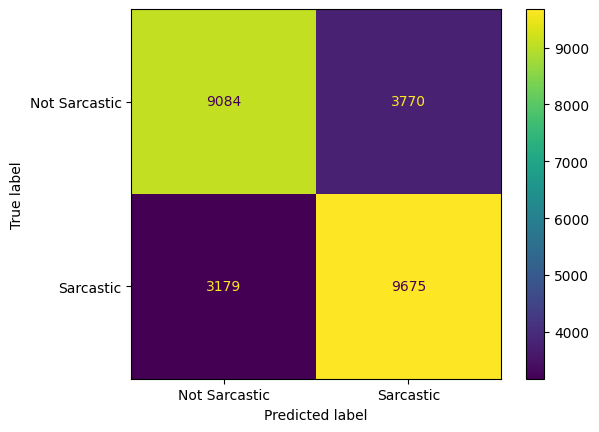

In [9]:
con_mat = metrics.confusion_matrix(model_out['gold'], model_out['pred'])
cm_graphic = metrics.ConfusionMatrixDisplay(con_mat, display_labels=['Not Sarcastic', 'Sarcastic'])
cm_graphic.plot()
plt.show()

In [10]:
baseline_matrix = confusion_matrix(baseline['gold'], baseline['pred'])

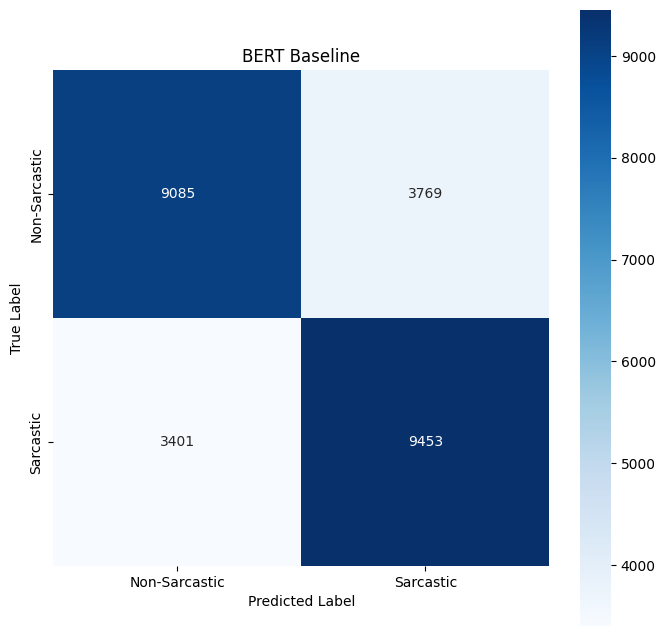

In [11]:
fig, axes = plt.subplots(1, figsize=(8, 8))

# BASELINE:
sns.heatmap(baseline_matrix, ax=axes, square=True, annot=True, fmt='g', cmap="Blues", xticklabels=["Non-Sarcastic", "Sarcastic"], yticklabels=["Non-Sarcastic", "Sarcastic"])
axes.set_ylabel('True Label')
axes.set_xlabel('Predicted Label')
axes.set_title('BERT Baseline')
plt.savefig('images/baseline_heatmap.png')
plt.show()

In [12]:
# matrices for all 4 models:
baseline_matrix = confusion_matrix(baseline['gold'], baseline['pred'])
roberta_matrix = confusion_matrix(roberta['gold'], roberta['pred'])
context_matrix = confusion_matrix(context['gold'], context['pred'])
combined_matrix = confusion_matrix(combined['gold'], combined['pred'])

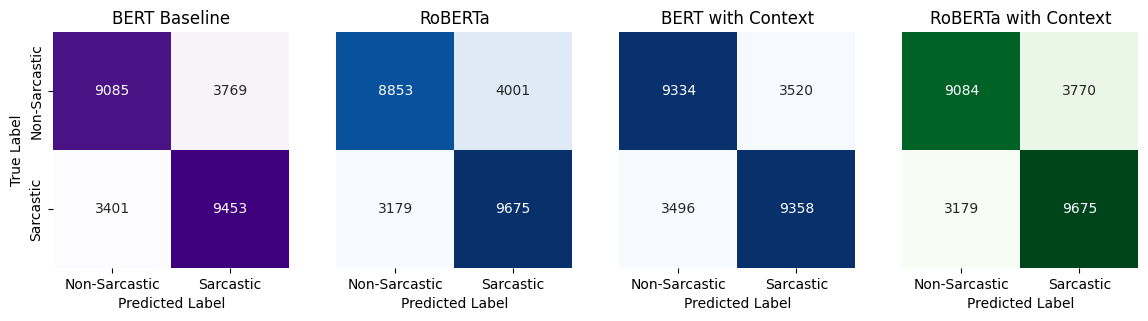

In [13]:
# add all heatmaps to one plot:
fig, axes = plt.subplots(1, 4, figsize=(14, 5.5))

sns.heatmap(baseline_matrix, ax=axes[0], cbar=False, square=True, annot=True, fmt='g', cmap="Purples", xticklabels=["Non-Sarcastic", "Sarcastic"], yticklabels=["Non-Sarcastic", "Sarcastic"])
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_title('BERT Baseline')

sns.heatmap(roberta_matrix, ax=axes[1], cbar=False, square=True, annot=True, fmt='g', cmap="Blues", xticklabels=["Non-Sarcastic", "Sarcastic"], yticklabels=False)
axes[1].set_xlabel('Predicted Label')
axes[1].set_title('RoBERTa')

sns.heatmap(context_matrix, ax=axes[2], cbar=False, square=True, annot=True, fmt='g', cmap="Blues", xticklabels=["Non-Sarcastic", "Sarcastic"], yticklabels=False)
axes[2].set_xlabel('Predicted Label')
axes[2].set_title('BERT with Context')

sns.heatmap(combined_matrix, ax=axes[3], cbar=False, square=True, annot=True, fmt='g', cmap="Greens", xticklabels=["Non-Sarcastic", "Sarcastic"], yticklabels=False)
axes[3].set_xlabel('Predicted Label')
axes[3].set_title('RoBERTa with Context')

plt.savefig('images/all_heatmaps.png')
plt.show()